In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

In [2]:
import torch

In [3]:
from behavior_model import LVBehaviorModel, FVBehaviorModel
from synthetic_model import LVTrajSynthetic, FVTrajSynthetic

In [4]:
file_path = 'Synthetic_crash_scenarios.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Model

In [6]:
## Network Parameters 
gru_hidden_size = 256 # Size of GRU's hidden layer
mlp_hidden_size = 128 # Size of MLP's hidden layer
acc_min, acc_max, acc_interval = -9.5, 7, 0.25
output_size = int((acc_max - acc_min)/acc_interval) + 1
input_size = 5

model_lv = LVBehaviorModel(input_size, gru_hidden_size, mlp_hidden_size, output_size).to(device)
model_lv.load_state_dict(torch.load('.\\weights\\bc_lv_val_dtw_02.pth')) 
model_lv.eval()

LVBehaviorModel(
  (gru): GRU(5, 256, batch_first=True)
  (mlp): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=67, bias=True)
    (3): LogSoftmax(dim=2)
  )
)

In [7]:
## Network Parameters 
acc_min, acc_max, acc_interval = -9.5, 4, 0.25
gru_hidden_size = 256 # Size of GRU's hidden layer
mlp_hidden_size = 128 # Size of MLP's hidden layer
output_size = int((acc_max - acc_min)/acc_interval) + 1
input_size = 5

model_fv = FVBehaviorModel(input_size, gru_hidden_size, mlp_hidden_size, output_size).to(device)
model_fv.load_state_dict(torch.load('.\\weights\\bc_fv_val_dtw_02.pth'))
model_fv.eval()

FVBehaviorModel(
  (gru): GRU(5, 256, batch_first=True)
  (mlp): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=55, bias=True)
    (3): LogSoftmax(dim=2)
  )
  (mlp2): Sequential(
    (0): Linear(in_features=97, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
)

# Crash Generation Example

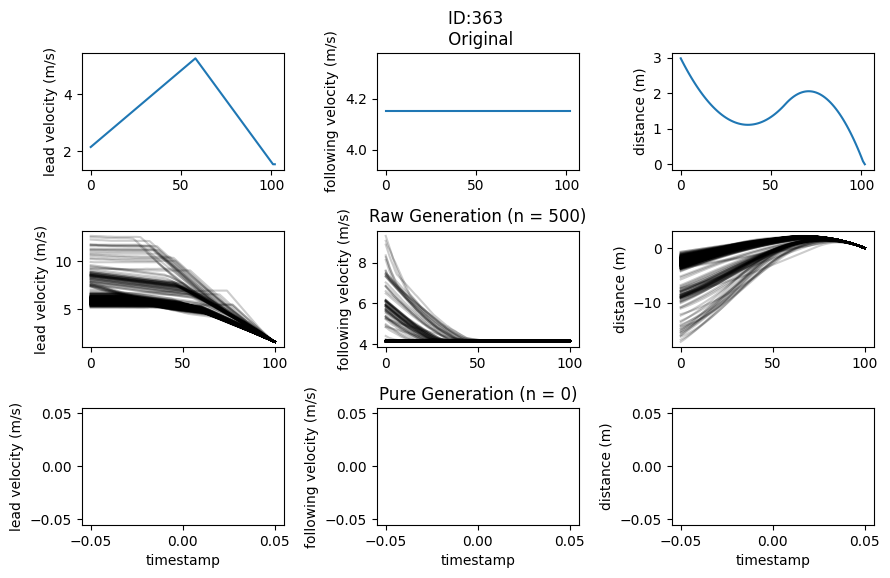

In [20]:
for _ in range(1):
#     ID = random.randint(1, 5000)
#     ID = 2530
#     ID = 1421
    ID = 363
    v_l_i = df[df["id"]==ID].iloc[:, 3].to_numpy()
    v_f_i = df[df["id"]==ID].iloc[:, 2].to_numpy()
    d_i = df[df["id"]==ID].iloc[:, 4].to_numpy()
    t_i = df[df["id"]==ID].iloc[:, 1].to_numpy()

    #### Gen LV first
    n = 500 # number of trajectories
    V_inputLV, A_inputLV = np.zeros(n), np.zeros(n)
    V_f0_inputLV, A_f0_inputLV = np.zeros(n), np.zeros(n)

    a_0 = (v_l_i[-2]-v_l_i[-3])/0.05
    # V_inputLV = V_inputLV+v_l_i[-1]
    V_inputLV = V_inputLV+v_l_i[-2]
    A_inputLV = A_inputLV+a_0
    V_f0_inputLV = V_f0_inputLV+v_f_i[-2]
    A_f0_inputLV = A_f0_inputLV+(v_f_i[-2]-v_f_i[-3])/0.05

    KM_l_LV = LVTrajSynthetic(model_lv,V_inputLV,A_inputLV,V_f0_inputLV,A_f0_inputLV,T_traj=5,mode="rs",device=device)
    ## KM_l_LV = np.flip(KM_l_LV,axis=1)

    V_f_inputFV, A_f_inputFV, D_inputFV = np.zeros(n), np.zeros(n), np.zeros(n)
    V_l_inputFV = np.zeros((n,KM_l_LV.shape[1]))

    a_f_0 = (v_f_i[-2]-v_f_i[-3])/0.05
    # V_f_inputFV = V_f_inputFV+v_f_i[-1]
    V_f_inputFV = V_f_inputFV+v_f_i[-2]
    A_f_inputFV = A_f_inputFV+a_f_0
    # D_inputFV = D_inputFV+d_i[-1]
    V_l_inputFV = copy.deepcopy(KM_l_LV[:,:,1])

    KM_l_FV, KM_f_FV = FVTrajSynthetic(model_fv,V_f_inputFV,A_f_inputFV,D_inputFV,V_l_inputFV,mode="rs",device=device)
#     KM_l_FV, KM_f_FV = TrajGen_FV_GRU2B(model_fv,V_f_inputFV,A_f_inputFV,D_inputFV,V_l_inputFV,mode="rs",device=device)
    KM_l, KM_f = np.flip(KM_l_FV,axis=1), np.flip(KM_f_FV,axis=1)
    
    V_l = copy.deepcopy(KM_l[:,:,1])
    V_f = copy.deepcopy(KM_f[:,:,1])
    D = copy.deepcopy(KM_l[:,:,0] - KM_f[:,:,0])
    idx_noprecrash = np.all(D[:,:-1] > 0, axis=1)
    idx_wrongvfacc = np.abs((V_f[:,-1]-V_f[:,-2])/0.05 - A_f_inputFV)<0.75
    idx_wrongvlacc = np.abs((V_l[:,-1]-V_l[:,-2])/0.05 - A_inputLV)<0.75
    idx_filter = np.all([idx_noprecrash,idx_wrongvfacc,idx_wrongvlacc],axis=0)
#     idx_filter = np.all([idx_noprecrash,idx_wrongvfacc],axis=0)
    V_l_filter, V_f_filter, D_filter = V_l[idx_filter], V_f[idx_filter], D[idx_filter]


    plt.figure(figsize=(9, 9))

    plt.subplot(5, 3, 1)
    plt.plot(df[df["id"]==ID].iloc[:, 3].to_numpy())
    plt.ylabel("lead velocity (m/s)")
    plt.subplot(5, 3, 2)
    plt.plot(df[df["id"]==ID].iloc[:, 2].to_numpy())
    plt.ylabel("following velocity (m/s)")
    plt.title(f"ID:{ID} \n Original")
    plt.subplot(5, 3, 3)
    plt.plot(df[df["id"]==ID].iloc[:, 4].to_numpy())
    plt.ylabel("distance (m)")

    plt.subplot(5, 3, 4)
    plt.plot(V_l.T, "k-", alpha=.2)
    plt.ylabel("lead velocity (m/s)")
    plt.subplot(5, 3, 5)
    plt.plot(V_f.T, "k-", alpha=.2)
    plt.title(f"Raw Generation (n = {n})")
    plt.ylabel("following velocity (m/s)")
    plt.subplot(5, 3, 6)
    plt.plot(D.T, "k-", alpha=.2)
    plt.ylabel("distance (m)")

    plt.subplot(5, 3, 7)
    plt.plot(V_l_filter.T, "k-", alpha=.2)
    plt.xlabel("timestamp")
    plt.ylabel("lead velocity (m/s)")
    plt.subplot(5, 3, 8)
    plt.plot(V_f_filter.T, "k-", alpha=.2)
    plt.title(f"Pure Generation (n = {V_f_filter.shape[0]})")
    plt.xlabel("timestamp")
    plt.ylabel("following velocity (m/s)")
    plt.subplot(5, 3, 9)
    plt.plot(D_filter.T, "k-", alpha=.2)
    plt.xlabel("timestamp")
    plt.ylabel("distance (m)") 

    plt.tight_layout()
    plt.show()

# Crash Generation

## initialize input

In [8]:
n = 5000
T_traj = 5
l_traj = int(T_traj/0.05+1)

## Initialize LV model and FV model input
V_inputLV, A_inputLV = np.zeros(n), np.zeros(n)
V_f0_inputLV, A_f0_inputLV = np.zeros(n), np.zeros(n)
V_f_inputFV, A_f_inputFV, D_inputFV = np.zeros(n), np.zeros(n), np.zeros(n)
V_l_inputFV = np.zeros((n,l_traj))

for ID in range(1,5001):
    v_l_i = df[df["id"]==ID].iloc[:, 3].to_numpy()
    v_f_i = df[df["id"]==ID].iloc[:, 2].to_numpy()
    
    ## input for LV model
    V_inputLV[ID-1] = v_l_i[-2]
    A_inputLV[ID-1] = (v_l_i[-2]-v_l_i[-3])/0.05
    V_f0_inputLV[ID-1] = v_f_i[-2]
    A_f0_inputLV[ID-1] = (v_f_i[-2]-v_f_i[-3])/0.05
    
    ## input for FV model
    V_f_inputFV[ID-1] = v_f_i[-2]
    A_f_inputFV[ID-1] = (v_f_i[-2]-v_f_i[-3])/0.05

## Generating

In [9]:
# list_crashes = []

# for _ in range(15):
    
#     #### generate LV first
#     KM_l_LV = LVTrajSynthetic(model_lv,V_inputLV,A_inputLV,V_f0_inputLV,A_f0_inputLV,T_traj=T_traj,mode="rs",device=device)
#     V_l_inputFV = copy.deepcopy(KM_l_LV[:,:,1]) ## Extract the LV trajectory (backward) for FV model input
    
#     #### Generate FV then
#     KM_l_FV, KM_f_FV = FVTrajSynthetic(model_fv,V_f_inputFV,A_f_inputFV,D_inputFV,V_l_inputFV,mode="rs",device=device)
#     KM_l, KM_f = np.flip(KM_l_FV,axis=1), np.flip(KM_f_FV,axis=1) ## make both LV and FV Kinematics Matrix forward
    
#     V_l = copy.deepcopy(KM_l[:,:,1])
#     V_f = copy.deepcopy(KM_f[:,:,1])
#     D = copy.deepcopy(KM_l[:,:,0] - KM_f[:,:,0])
#     idx_filter =  np.all(D[:,:-1] > 0, axis=1)
#     V_l_filter, V_f_filter, D_filter = V_l[idx_filter], V_f[idx_filter], D[idx_filter]
#     print(f"qualified rate = {round(D_filter.shape[0]/5000,3)}") # no pre-crash (before the last crash) rate
    
#     ite = 0
#     while True:
#         ite += 1
#         print(f"iteration:{ite}")
        
#         ## extract the input that generated unqualified case
#         idx_regen = ~idx_filter
#         V_inputLV_regen, A_inputLV_regen = V_inputLV[idx_regen], A_inputLV[idx_regen] 
#         V_f0_inputLV_regen, A_f0_inputLV_regen = V_f0_inputLV[idx_regen], A_f0_inputLV[idx_regen] 
#         V_f_inputFV_regen, A_f_inputFV_regen, D_inputFV_regen = V_f_inputFV[idx_regen], A_f_inputFV[idx_regen], D_inputFV[idx_regen]
        
#         if V_inputLV_regen.shape[0] == 0: ## no unqualified case
#             break
            
#         #### generate LV first
#         KM_l_LV_regen = LVTrajSynthetic(model_lv,V_inputLV_regen,A_inputLV_regen,V_f0_inputLV_regen, A_f0_inputLV_regen,T_traj=T_traj,mode="rs",device=device)
#         V_l_inputFV_regen = copy.deepcopy(KM_l_LV_regen[:,:,1]) ## Extract the LV trajectory (backward) for FV model input
#         #### Generate FV then
#         KM_l_FV_regen, KM_f_FV_regen = FVTrajSynthetic(model_fv,V_f_inputFV_regen,A_f_inputFV_regen,D_inputFV_regen,V_l_inputFV_regen,mode="rs",device=device)
#         KM_l_regen, KM_f_regen = np.flip(KM_l_FV_regen,axis=1), np.flip(KM_f_FV_regen,axis=1) ## make both LV and FV Kinematics Matrix forward
        
#         # V_l_regen = copy.deepcopy(KM_l_regen[:,:,1])
#         # V_f_regen = copy.deepcopy(KM_f_regen[:,:,1])
#         D_regen = copy.deepcopy(KM_l_regen[:,:,0] - KM_f_regen[:,:,0])
#         idx_filter_regen = np.all(D_regen[:,:-1] > 0, axis=1)
#         D_filter_regen = D_regen[idx_filter_regen]
#         print(f"total re-generation number: {D_regen.shape[0]}, no pre-crash number: {D_filter_regen.shape[0]}")
        
#         ## replace the uncrashes events
#         KM_f[idx_regen], KM_l[idx_regen] = KM_f_regen, KM_l_regen
#         V_l = copy.deepcopy(KM_l[:,:,1])
#         V_f = copy.deepcopy(KM_f[:,:,1])
#         D = copy.deepcopy(KM_l[:,:,0] - KM_f[:,:,0])
#         idx_filter = np.all(D[:,:-1] > 0, axis=1) # new qualified index
        
#     Arr_crashes = np.empty((n,l_traj,3))
#     Arr_crashes[:,:,0] = copy.deepcopy(V_l)
#     Arr_crashes[:,:,1] = copy.deepcopy(V_f)
#     Arr_crashes[:,:,2] = copy.deepcopy(D)
    
#     list_crashes.append(Arr_crashes)

## Save as dataframe

In [10]:
# for i in range(len(list_crashes)):
    
#     Arr_crashes = list_crashes[i]
#     length = Arr_crashes.shape[1]
    
#     t_intv = 0.05
#     n_crash = Arr_crashes.shape[0]
#     IDs = np.arange(1,n_crash+1)
#     t = np.arange(0, -5.1, -t_intv)[:length]
#     t = np.flip(t)
#     lead_delta_v_all = df[df["t"]==0].iloc[:, 5].to_numpy()
#     weights = df[df["t"]==0].iloc[:, 6].to_numpy()
    
#     d = {'id': np.repeat(IDs,length),
#          'idx': np.ones(n_crash*length,dtype=int)+i,
#          't': np.tile(t,n_crash),
#          'v_f': Arr_crashes[:,:,1].reshape(1,-1).reshape(-1),
#          'v_l': Arr_crashes[:,:,0].reshape(1,-1).reshape(-1),
#          'd': Arr_crashes[:,:,2].reshape(1,-1).reshape(-1),
#          'lead_delta_v': np.repeat(lead_delta_v_all,length),
#          'weight': np.repeat(weights,length)
#     }
#     if i == 0:
#         df_crashes = pd.DataFrame(data=d)
#     else:
#         df_i = pd.DataFrame(data=d)
#         df_crashes = pd.concat([df_crashes, df_i], axis=0, ignore_index=True)

## Combination

In [14]:
# np.arange(1,5001)[~idx_filter]

array([  25,   56,  153,  299,  363, 3821, 4049])

In [11]:
for idx in range(15):
    
    #### generate LV first
    KM_l_LV = LVTrajSynthetic(model_lv,V_inputLV,A_inputLV,V_f0_inputLV,A_f0_inputLV,T_traj=T_traj,mode="rs",device=device)
    V_l_inputFV = copy.deepcopy(KM_l_LV[:,:,1]) ## Extract the LV trajectory (backward) for FV model input
    
    #### Generate FV then
    KM_l_FV, KM_f_FV = FVTrajSynthetic(model_fv,V_f_inputFV,A_f_inputFV,D_inputFV,V_l_inputFV,mode="rs",device=device)
    KM_l, KM_f = np.flip(KM_l_FV,axis=1), np.flip(KM_f_FV,axis=1) ## make both LV and FV Kinematics Matrix forward
    
    V_l = copy.deepcopy(KM_l[:,:,1])
    V_f = copy.deepcopy(KM_f[:,:,1])
    D = copy.deepcopy(KM_l[:,:,0] - KM_f[:,:,0])
    idx_filter =  np.all(D[:,:-1] > 0, axis=1)
    V_l_filter, V_f_filter, D_filter = V_l[idx_filter], V_f[idx_filter], D[idx_filter]
    print(f"qualified rate = {round(D_filter.shape[0]/5000,3)}") # no pre-crash (before the last crash) rate
    
    ite = 0
    while True:
        ite += 1
        print(f"iteration:{ite}")
        
        ## extract the input that generated unqualified case
        idx_regen = ~idx_filter
        V_inputLV_regen, A_inputLV_regen = V_inputLV[idx_regen], A_inputLV[idx_regen] 
        V_f0_inputLV_regen, A_f0_inputLV_regen = V_f0_inputLV[idx_regen], A_f0_inputLV[idx_regen] 
        V_f_inputFV_regen, A_f_inputFV_regen, D_inputFV_regen = V_f_inputFV[idx_regen], A_f_inputFV[idx_regen], D_inputFV[idx_regen]
        
        if V_inputLV_regen.shape[0] == 0: ## no unqualified case
            break
            
        #### generate LV first
        KM_l_LV_regen = LVTrajSynthetic(model_lv,V_inputLV_regen,A_inputLV_regen,V_f0_inputLV_regen, A_f0_inputLV_regen,T_traj=T_traj,mode="rs",device=device)
        V_l_inputFV_regen = copy.deepcopy(KM_l_LV_regen[:,:,1]) ## Extract the LV trajectory (backward) for FV model input
        #### Generate FV then
        KM_l_FV_regen, KM_f_FV_regen = FVTrajSynthetic(model_fv,V_f_inputFV_regen,A_f_inputFV_regen,D_inputFV_regen,V_l_inputFV_regen,mode="rs",device=device)
        KM_l_regen, KM_f_regen = np.flip(KM_l_FV_regen,axis=1), np.flip(KM_f_FV_regen,axis=1) ## make both LV and FV Kinematics Matrix forward
        
        # V_l_regen = copy.deepcopy(KM_l_regen[:,:,1])
        # V_f_regen = copy.deepcopy(KM_f_regen[:,:,1])
        D_regen = copy.deepcopy(KM_l_regen[:,:,0] - KM_f_regen[:,:,0])
        idx_filter_regen = np.all(D_regen[:,:-1] > 0, axis=1)
        D_filter_regen = D_regen[idx_filter_regen]
        print(f"total re-generation number: {D_regen.shape[0]}, no pre-crash number: {D_filter_regen.shape[0]}")
        
        ## replace the uncrashes events
        KM_f[idx_regen], KM_l[idx_regen] = KM_f_regen, KM_l_regen
        V_l = copy.deepcopy(KM_l[:,:,1])
        V_f = copy.deepcopy(KM_f[:,:,1])
        D = copy.deepcopy(KM_l[:,:,0] - KM_f[:,:,0])
        idx_filter = np.all(D[:,:-1] > 0, axis=1) # new qualified index
        
    
    t_intv = 0.05
    IDs = np.arange(1,n+1)
    t = np.arange(0, -5.1, -t_intv)[:l_traj]
    t = np.flip(t)
    
    d = {'id': np.repeat(IDs,l_traj),
         'idx': np.ones(IDs.shape[0]*l_traj,dtype=int)+idx,
         't': np.tile(t,IDs.shape[0]),
         'v_f': V_f.reshape(1,-1).reshape(-1),
         'v_l': V_l.reshape(1,-1).reshape(-1),
         'd': D.reshape(1,-1).reshape(-1),
         'lead_delta_v': np.repeat(df[df["t"]==0].iloc[:, 5].to_numpy(),l_traj),
         'weight': np.repeat(df[df["t"]==0].iloc[:, 6].to_numpy(),l_traj)
    }
    
    if idx == 0:
        df_crashes = pd.DataFrame(data=d)
    else:
        df_idx = pd.DataFrame(data=d)
        df_crashes = pd.concat([df_crashes, df_idx], axis=0, ignore_index=True)

qualified rate = 0.929
iteration:1
total re-generation number: 355, no pre-crash number: 174
iteration:2
total re-generation number: 181, no pre-crash number: 62
iteration:3
total re-generation number: 119, no pre-crash number: 25
iteration:4
total re-generation number: 94, no pre-crash number: 11
iteration:5
total re-generation number: 83, no pre-crash number: 6
iteration:6
total re-generation number: 77, no pre-crash number: 4
iteration:7
total re-generation number: 73, no pre-crash number: 10
iteration:8
total re-generation number: 63, no pre-crash number: 7
iteration:9
total re-generation number: 56, no pre-crash number: 4
iteration:10
total re-generation number: 52, no pre-crash number: 2
iteration:11
total re-generation number: 50, no pre-crash number: 2
iteration:12
total re-generation number: 48, no pre-crash number: 1
iteration:13
total re-generation number: 47, no pre-crash number: 1
iteration:14
total re-generation number: 46, no pre-crash number: 4
iteration:15
total re-gen

total re-generation number: 10, no pre-crash number: 0
iteration:122
total re-generation number: 10, no pre-crash number: 1
iteration:123
total re-generation number: 9, no pre-crash number: 0
iteration:124
total re-generation number: 9, no pre-crash number: 0
iteration:125
total re-generation number: 9, no pre-crash number: 0
iteration:126
total re-generation number: 9, no pre-crash number: 0
iteration:127
total re-generation number: 9, no pre-crash number: 1
iteration:128
total re-generation number: 8, no pre-crash number: 0
iteration:129
total re-generation number: 8, no pre-crash number: 0
iteration:130
total re-generation number: 8, no pre-crash number: 0
iteration:131
total re-generation number: 8, no pre-crash number: 0
iteration:132
total re-generation number: 8, no pre-crash number: 0
iteration:133
total re-generation number: 8, no pre-crash number: 0
iteration:134
total re-generation number: 8, no pre-crash number: 0
iteration:135
total re-generation number: 8, no pre-crash nu

total re-generation number: 7, no pre-crash number: 0
iteration:243
total re-generation number: 7, no pre-crash number: 0
iteration:244
total re-generation number: 7, no pre-crash number: 0
iteration:245
total re-generation number: 7, no pre-crash number: 0
iteration:246
total re-generation number: 7, no pre-crash number: 0
iteration:247
total re-generation number: 7, no pre-crash number: 0
iteration:248
total re-generation number: 7, no pre-crash number: 0
iteration:249
total re-generation number: 7, no pre-crash number: 0
iteration:250
total re-generation number: 7, no pre-crash number: 0
iteration:251
total re-generation number: 7, no pre-crash number: 0
iteration:252
total re-generation number: 7, no pre-crash number: 0
iteration:253
total re-generation number: 7, no pre-crash number: 0
iteration:254
total re-generation number: 7, no pre-crash number: 0
iteration:255
total re-generation number: 7, no pre-crash number: 0
iteration:256
total re-generation number: 7, no pre-crash numb

total re-generation number: 7, no pre-crash number: 0
iteration:364
total re-generation number: 7, no pre-crash number: 0
iteration:365
total re-generation number: 7, no pre-crash number: 0
iteration:366
total re-generation number: 7, no pre-crash number: 0
iteration:367
total re-generation number: 7, no pre-crash number: 0
iteration:368
total re-generation number: 7, no pre-crash number: 0
iteration:369
total re-generation number: 7, no pre-crash number: 0
iteration:370
total re-generation number: 7, no pre-crash number: 0
iteration:371
total re-generation number: 7, no pre-crash number: 0
iteration:372
total re-generation number: 7, no pre-crash number: 0
iteration:373
total re-generation number: 7, no pre-crash number: 0
iteration:374
total re-generation number: 7, no pre-crash number: 0
iteration:375
total re-generation number: 7, no pre-crash number: 0
iteration:376
total re-generation number: 7, no pre-crash number: 0
iteration:377
total re-generation number: 7, no pre-crash numb

KeyboardInterrupt: 

In [ ]:
df_crashes

In [ ]:
df_crashes.to_csv('Synthetic_Crash_dtw_02.csv', index=False)

# Clustering PostProcess

First, read v_l, v_f, d, and their corresponding  weight

## Read from file

In [2]:
df_raw = pd.read_csv('Synthetic_crash_scenarios.csv')
df_gen = pd.read_csv('Synthetic_Crash_02.csv')
y_raw = np.load('.\\utils_data\\hc_y.npy')
dist_thresholds = np.load('.\\utils_data\\hc_olddtw_dist_thres.npy')

In [3]:
## read the ID of train, val, test dataset
import pickle
with open('.\\utils_data\\Idx_02_split.pkl', 'rb') as f:
    list_train_val_test = pickle.load(f)
list_train_val_test = list_train_val_test[0]

ID_train, ID_val, ID_test = list_train_val_test[0], list_train_val_test[1], list_train_val_test[2]
ID_train, ID_val, ID_test = ID_train+1, ID_val+1, ID_test+1

In [4]:
df_gen["split_type"] = np.full(df_gen.shape[0],np.nan)
df_gen["split_type"] = df_gen["split_type"].astype('string')
df_gen.loc[df_gen["id"].isin(ID_train),"split_type"] = "train"
df_gen.loc[df_gen["id"].isin(ID_val),"split_type"] = "val"
df_gen.loc[df_gen["id"].isin(ID_test),"split_type"] = "test"

In [5]:
df_gen

,id,idx,t,v_f,v_l,d,lead_delta_v,weight,split_type
0,1,1,-5.00,0.000000,0.0375,0.138000,0.809665,0.012977,val
1,1,1,-4.95,0.000000,0.0375,0.139875,0.809665,0.012977,val
2,1,1,-4.90,0.000000,0.0375,0.141750,0.809665,0.012977,val
3,1,1,-4.85,0.000000,0.0375,0.143625,0.809665,0.012977,val
4,1,1,-4.80,0.000000,0.0375,0.145500,0.809665,0.012977,val
...,...,...,...,...,...,...,...,...,...
7574995,5000,15,-0.20,1.836731,0.6090,0.149296,0.122524,1.429095,test
7574996,5000,15,-0.15,1.599231,0.6090,0.093847,0.122524,1.429095,test
7574997,5000,15,-0.10,1.349231,0.6090,0.050586,0.122524,1.429095,test
7574998,5000,15,-0.05,1.111731,0.6090,0.019512,0.122524,1.429095,test


In [6]:
from utils_cluster import genNormalizedX

## Raw Data

In [7]:
V_l = np.zeros((5000,97))
V_f = np.zeros((5000,97))
D = np.zeros((5000,97))
Weight = np.zeros(5000)
for i in range(1,5001):
    v_l_i = df_raw[df_raw["id"]==i].iloc[-98:-1, 3].to_numpy()
    v_f_i = df_raw[df_raw["id"]==i].iloc[-98:-1, 2].to_numpy()
    d_i = df_raw[df_raw["id"]==i].iloc[-98:-1, 4].to_numpy() - df_raw[df_raw["id"]==i].iloc[-2, 4]
    weight_i = df_raw[df_raw["id"]==i].iloc[0, 6]
    V_l[i-1,:], V_f[i-1,:], D[i-1,:] = v_l_i, v_f_i, d_i
    Weight[i-1] = weight_i

import copy
V_l_raw = copy.deepcopy(V_l)
V_f_raw = copy.deepcopy(V_f)
D_raw = copy.deepcopy(D)
Weight_raw = copy.deepcopy(Weight)

X_raw = genNormalizedX(V_l_raw,V_f_raw,D_raw)

## Gen Data

In [8]:
# import copy
# ID_eva = copy.deepcopy(ID_test)

filter_gen_eva_wot = np.all(
    [
        # df_gen["id"].isin(ID_eva),
        df_gen["idx"]<=5,
        # df_gen["t"]>-4.84,
    ],
    axis=0
)
filter_gen_eva = np.all(
    [
        df_gen["t"]>-4.84,
        filter_gen_eva_wot,
    ],
    axis=0
)

df_gen_eva = df_gen[filter_gen_eva].reset_index(drop=True)

In [9]:
V_f_gen_eva = df_gen_eva['v_f'].to_numpy()
V_l_gen_eva = df_gen_eva['v_l'].to_numpy()
D_gen_eva = df_gen_eva['d'].to_numpy()
Weight_gen_eva = df_gen_eva['weight'].to_numpy()

V_f_gen_eva = V_f_gen_eva.reshape(-1,97)
V_l_gen_eva = V_l_gen_eva.reshape(-1,97)
D_gen_eva = D_gen_eva.reshape(-1,97)
Weight_gen_eva = Weight_gen_eva[::97]

X_gen_eva = genNormalizedX(V_l_gen_eva,V_f_gen_eva,D_gen_eva)

Then, calculate the distance matrix

## Calculate DM

In [10]:
# dm_rawgen = pdist(X_gen_eva[:,:,1], X[:,:,1], lambda u, v: fastdtw(u, v)[0])

In [11]:
# # !pip install pycuda
# # !pip install pyopencl
# # !pip install GPUDTW

# from GPUDTW import cuda_dtw
# from GPUDTW import opencl_dtw
# from GPUDTW import cpu_dtw, dtw_1D_jit2

# S = np.random.random ((50,100))
# S = S.astype(np.float32)

# dm = cpu_dtw(S, S, dtw_1D_jit2)
# dm = cuda_dtw(S, S)

Use distance matrix to do clustering

## Clustering

In [12]:
# dm_rawgen1 = np.load('.\\utils_data\\hc_dm_02_test1.npy')
# dm_rawgen2 = np.load('.\\utils_data\\hc_dm_02_test2.npy')
# dm_rawgen3 = np.load('.\\utils_data\\hc_dm_02_test3.npy')
# dm_rawgen = np.vstack((dm_rawgen1, dm_rawgen2, dm_rawgen3))

dm_rawgen = np.load('.\\utils_data\\hc_dtw_dm_02_12345.npy')

In [13]:
def assign_label_based_on_dm(dm_rawgen,y_raw):
    labels = np.unique(y_raw)
    min_dist = np.zeros((dm_rawgen.shape[0],labels.shape[0]))
    for i_label, label in enumerate(labels):
        min_dist[:,i_label] = np.min(dm_rawgen[:,y_raw==label],axis=1)
    
    y_gen = labels[np.argsort(min_dist,axis=1)[:,0]]
    return y_gen, min_dist

In [14]:
y_gen, min_dist = assign_label_based_on_dm(dm_rawgen,y_raw)

In [15]:
df_gen["label"] = np.full(df_gen.shape[0],np.nan)
df_gen.loc[filter_gen_eva_wot,"label"] = np.repeat(y_gen,101)
df_gen["label"] = df_gen["label"].astype('Int64')
df_gen

,id,idx,t,v_f,v_l,d,lead_delta_v,weight,split_type,label
0,1,1,-5.00,0.000000,0.0375,0.138000,0.809665,0.012977,val,60902
1,1,1,-4.95,0.000000,0.0375,0.139875,0.809665,0.012977,val,60902
2,1,1,-4.90,0.000000,0.0375,0.141750,0.809665,0.012977,val,60902
3,1,1,-4.85,0.000000,0.0375,0.143625,0.809665,0.012977,val,60902
4,1,1,-4.80,0.000000,0.0375,0.145500,0.809665,0.012977,val,60902
...,...,...,...,...,...,...,...,...,...,...
7574995,5000,15,-0.20,1.836731,0.6090,0.149296,0.122524,1.429095,test,<NA>
7574996,5000,15,-0.15,1.599231,0.6090,0.093847,0.122524,1.429095,test,<NA>
7574997,5000,15,-0.10,1.349231,0.6090,0.050586,0.122524,1.429095,test,<NA>
7574998,5000,15,-0.05,1.111731,0.6090,0.019512,0.122524,1.429095,test,<NA>


In [16]:
# np.save(".\\utils_data\\hc_y_02_test123.npy",y_gen)

## Clustering filter

In [17]:
import copy

labels = np.unique(y_raw)
y_gen_filter = copy.deepcopy(y_gen)

for i_cls, label in enumerate(labels):
    
    min_dist_cls = min_dist[np.argsort(min_dist,axis=1)[:,0]==i_cls, i_cls]
    y_gen_filter_cls = y_gen_filter[y_gen_filter==label]
    y_gen_filter_cls[min_dist_cls>dist_thresholds[i_cls]] = -1
    y_gen_filter[y_gen_filter==label] = y_gen_filter_cls

In [18]:
df_gen["qualify"] = np.full(df_gen.shape[0],np.nan)
df_gen["qualify"] = df_gen["qualify"].astype('boolean')
df_gen.loc[filter_gen_eva_wot,"qualify"] = np.repeat(y_gen_filter != -1,101)
df_gen

,id,idx,t,v_f,v_l,d,lead_delta_v,weight,split_type,label,qualify
0,1,1,-5.00,0.000000,0.0375,0.138000,0.809665,0.012977,val,60902,False
1,1,1,-4.95,0.000000,0.0375,0.139875,0.809665,0.012977,val,60902,False
2,1,1,-4.90,0.000000,0.0375,0.141750,0.809665,0.012977,val,60902,False
3,1,1,-4.85,0.000000,0.0375,0.143625,0.809665,0.012977,val,60902,False
4,1,1,-4.80,0.000000,0.0375,0.145500,0.809665,0.012977,val,60902,False
...,...,...,...,...,...,...,...,...,...,...,...
7574995,5000,15,-0.20,1.836731,0.6090,0.149296,0.122524,1.429095,test,<NA>,<NA>
7574996,5000,15,-0.15,1.599231,0.6090,0.093847,0.122524,1.429095,test,<NA>,<NA>
7574997,5000,15,-0.10,1.349231,0.6090,0.050586,0.122524,1.429095,test,<NA>,<NA>
7574998,5000,15,-0.05,1.111731,0.6090,0.019512,0.122524,1.429095,test,<NA>,<NA>


In [19]:
np.unique(y_gen_filter)

array([   -1, 10000, 20100, 20200, 31800, 31900, 32100, 40000, 50100,
       50200, 60901, 60902, 60903, 60904, 61801, 61802, 61803, 61804,
       61805, 63801, 63802, 63803])

In [20]:
# np.save(".\\utils_data\\hc_y_02_test123.npy",np.array([y_gen,y_gen_filter]))

## Clustering Reweighting

In [21]:
def proportionTable(Y,W,n_cluster=6):
    '''
    Y: List; W: List
    '''
    labels = np.unique(Y[0])
    table_proportion = np.empty((len(Y),labels.shape[0]))
    i = 0
    for y,w in zip(Y,W):
        w_sum = np.sum(w)
        for i_c, cls in enumerate(labels):
            w_sum_cls = np.sum(w[y == cls])
            table_proportion[i,i_c] = w_sum_cls/w_sum*100
        i+=1
            
    return pd.DataFrame(table_proportion, columns=np.unique(Y[0]))

In [22]:
# import copy
# ID_eva = copy.deepcopy(ID_train)

filter_gen_train = np.all(
    [
        df_gen["id"].isin(ID_train),
        df_gen["t"]>-4.84,
        df_gen["idx"]<=5,
        df_gen["split_type"]=="train",
        df_gen["qualify"]==True,
    ],
    axis=0
)
df_gen_train = df_gen[filter_gen_train].reset_index(drop=True)

In [23]:
Weight_gen_train = df_gen_train['weight'].to_numpy()
y_gen_train = df_gen_train['label'].to_numpy()

Weight_gen_train = Weight_gen_train[::97]
y_gen_train = y_gen_train[::97]

In [28]:
proportionTable([y_raw[ID_train-1],y_gen_train],[Weight_raw[ID_train-1],Weight_gen_train])

,10000,20100,20200,31800,31900,32100,40000,50100,50200,60901,...,60903,60904,61801,61802,61803,61804,61805,63801,63802,63803
0,10.112864,3.476522,11.486548,0.330590,4.131122,1.618363,0.243444,0.019662,1.557039,0.838156,...,2.251491,3.947176,0.696542,0.424987,2.124234,0.742291,0.631001,22.069690,19.081338,7.363635
1,0.488533,1.519909,8.851092,0.023302,5.873818,0.226066,0.137072,0.000000,0.000000,0.216024,...,0.014858,1.192210,1.470174,5.116783,1.832342,0.730359,1.636598,27.682118,29.064698,5.857292


In [70]:
proportionTable([y_raw[ID_test-1],y_gen],[Weight_raw[ID_test-1],Weight_gen_eva])

,10000,20100,20200,31800,31900,32100,40000,50100,50200,60901,...,60903,60904,61801,61802,61803,61804,61805,63801,63802,63803
0,9.576273,3.079363,11.156699,0.741572,4.445646,1.881391,0.429521,0.681757,1.461104,1.541940,...,1.705479,3.791599,1.424809,1.352560,2.406307,0.665984,0.503180,21.321880,18.058807,7.470196
1,7.740324,1.935692,8.124609,0.879912,3.156260,1.663628,0.810156,0.705952,1.553953,0.055575,...,0.461937,1.447939,1.386032,8.285565,4.808090,0.633903,1.024677,28.219159,15.991868,4.866835


In [73]:
proportionTable([y_raw[ID_test-1],y_gen,y_gen_filter[y_gen_filter!=-1]],[Weight_raw[ID_test-1],Weight_gen_eva,Weight_gen_eva[y_gen_filter!=-1]])

,10000,20100,20200,31800,31900,32100,40000,50100,50200,60901,...,60903,60904,61801,61802,61803,61804,61805,63801,63802,63803
0,9.576273,3.079363,11.156699,0.741572,4.445646,1.881391,0.429521,0.681757,1.461104,1.541940,...,1.705479,3.791599,1.424809,1.352560,2.406307,0.665984,0.503180,21.321880,18.058807,7.470196
1,7.740324,1.935692,8.124609,0.879912,3.156260,1.663628,0.810156,0.705952,1.553953,0.055575,...,0.461937,1.447939,1.386032,8.285565,4.808090,0.633903,1.024677,28.219159,15.991868,4.866835
2,2.037358,2.373748,4.647230,0.684624,2.497279,0.864644,0.818466,0.354647,0.063472,0.000000,...,0.445325,0.727335,0.004213,7.316417,5.315818,0.077084,0.625705,35.048780,23.033630,6.471969
